### Add scripts path to the notebook

In [2]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\notebooks


### Import Statements

In [3]:
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

from scripts.database_client import DB_Client


### Initialize DB_Client

In [4]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")

In [5]:
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

### Load the data from the database

In [6]:
data = db_client.dump_data()

d:\KifiyaAIM-Course\Week - 2\TellCo-Profitability-Opportunity-Analysis\scripts\database_client.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


### Data Cleaning

In [7]:
data.isna().mean()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.007107
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.185525
Avg RTT UL (ms)                             0.185412
Avg Bearer TP DL (kbps)                     0.000007
Avg Bearer TP UL (kbps)                     0.000007
TCP DL Retrans. Vol (Bytes)                 0.587636
TCP UL Retrans. Vol (Bytes)                 0.644322
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

As described in the _user_overview_analysis.ipynb_ since the data has a lot of missing vlaues in some columns droping the rows isn't the best option. So only cleanning the features that are important/relevant to the current task is the better option. The features of interest(columns) with null values are put in a list and the cleaning only happens in those columns, just for the specific task

In [8]:
columns_of_interest = ["MSISDN/Number", "IMSI", "Bearer Id", "Start", "Start ms", "End", "End ms", "Dur. (ms)", "Dur. (ms).1"]
data[columns_of_interest].isna().mean()

MSISDN/Number    0.007107
IMSI             0.003800
Bearer Id        0.006607
Start            0.000007
Start ms         0.000007
End              0.000007
End ms           0.000007
Dur. (ms)        0.000007
Dur. (ms).1      0.000007
dtype: float64

I have decided to drop the missing values found in the given columns because the amount of data we loose is very little

In [9]:
data.dropna(subset=columns_of_interest, inplace=True)

### Tracking user engagement 

1) Group data based on the MSISDN (phone number)

In [10]:
customer_grouping = data.groupby(by="MSISDN/Number")

2) Aggregate the required data. Since every entry in the database is a session we have to group them by the phone numebr, which we did above, and then calculate the total frequency by adding the unique _Bearer Id / sessionId_, summing up the download and upload byets for the sessions, and also adding the durations per sessions

In [11]:
customer_data = customer_grouping.agg({
    "Bearer Id": "count", # count the amount of session per sim card
    "Dur. (ms)": "sum", # calculate the total duration per sim card in the data
    "Total UL (Bytes)":  "sum", #calculate the total upload per sim card
    "Total DL (Bytes)": "sum", # calculate the total download per sim card 
})

# finding the total trafic(sum between total download and uplaod)
customer_data["traffic"] = customer_data["Total UL (Bytes)"] + customer_data["Total DL (Bytes)"]

# renaming the fields
customer_data.rename(columns={
    "Bearer Id": "session_freq",
    "Dur. (ms)": "duration",
    "Total UL (Bytes)": "upload_tot",
    "Total DL (Bytes)": "download_tot"
}, inplace=True)

In [12]:
customer_data.columns

Index(['session_freq', 'duration', 'upload_tot', 'download_tot', 'traffic'], dtype='object')

3) Reporting the top 10 customers per metric

In [13]:
# find the top 10 users for session frequency
frequency_order = customer_data.sort_values(by="session_freq", ascending=False)
frequency_order.head(10)

,session_freq,duration,upload_tot,download_tot,traffic
MSISDN/Number,,,,,
3.362632e+10,18,8791927.0,669650721.0,7.301517e+09,7.971167e+09
3.361489e+10,17,9966898.0,689483001.0,8.156743e+09,8.846226e+09
3.362578e+10,17,18553754.0,729577380.0,7.770043e+09,8.499621e+09
3.365973e+10,16,4035428.0,624260321.0,7.081602e+09,7.705863e+09
3.376054e+10,15,9279434.0,703478581.0,7.811295e+09,8.514774e+09
3.367588e+10,15,4865947.0,581568792.0,7.309542e+09,7.891111e+09
3.366716e+10,13,8744914.0,566326364.0,5.052068e+09,5.618394e+09
3.376041e+10,12,5321667.0,521518890.0,6.610852e+09,7.132371e+09
3.378632e+10,12,4059652.0,466330265.0,5.155901e+09,5.622232e+09


In [14]:
# find the top 10 users for session duration
duration_order = customer_data.sort_values(by="duration", ascending=False)
duration_order.head(10)

,session_freq,duration,upload_tot,download_tot,traffic
MSISDN/Number,,,,,
3.362578e+10,17,18553754.0,729577380.0,7.770043e+09,8.499621e+09
3.361489e+10,17,9966898.0,689483001.0,8.156743e+09,8.846226e+09
3.376054e+10,15,9279434.0,703478581.0,7.811295e+09,8.514774e+09
3.362632e+10,18,8791927.0,669650721.0,7.301517e+09,7.971167e+09
3.366716e+10,13,8744914.0,566326364.0,5.052068e+09,5.618394e+09
3.366284e+10,9,6614270.0,406424372.0,3.593674e+09,4.000098e+09
3.366469e+10,9,6288730.0,402180804.0,5.279827e+09,5.682007e+09
3.360313e+10,12,6287761.0,435587631.0,4.540607e+09,4.976195e+09
3.366746e+10,6,5649882.0,266222647.0,2.334299e+09,2.600522e+09


In [15]:
# find the top 10 users by total traffic 
traffic_order = customer_data.sort_values(by="traffic", ascending=False)
traffic_order.head(10)

,session_freq,duration,upload_tot,download_tot,traffic
MSISDN/Number,,,,,
3.361489e+10,17,9966898.0,689483001.0,8.156743e+09,8.846226e+09
3.376054e+10,15,9279434.0,703478581.0,7.811295e+09,8.514774e+09
3.362578e+10,17,18553754.0,729577380.0,7.770043e+09,8.499621e+09
3.362632e+10,18,8791927.0,669650721.0,7.301517e+09,7.971167e+09
3.367588e+10,15,4865947.0,581568792.0,7.309542e+09,7.891111e+09
3.365973e+10,16,4035428.0,624260321.0,7.081602e+09,7.705863e+09
3.366646e+10,11,4536757.0,405060976.0,6.903440e+09,7.308501e+09
3.376041e+10,12,5321667.0,521518890.0,6.610852e+09,7.132371e+09
3.366471e+10,11,2927785.0,471244453.0,6.400774e+09,6.872018e+09


### Classifying users into three groups of engagement

1) Normalize the data in each field

In [16]:
user_normalizer = Normalizer().fit(X=customer_data)
normalized_data = user_normalizer.transform(X=customer_data)
normalized_data = pd.DataFrame(columns=customer_data.columns, index=customer_data.index, data=normalized_data)

2) Run a k-mean where k=3 to classify customers in three groups of engagement

    Parameters of the clustering class
    - n_clusters = 3: to classify our users into 3 engagement groups/clusters
    - init = 'k-means++': selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia, chose it because convergence is faster.
    - n_init = 50: let the algorithm run for 50 times 

In [17]:
# intialize the clustering algorithm
clusterer = KMeans(n_clusters=3, random_state=7, init='k-means++', n_init='auto')

# clustering our users 
engagement_clusters = clusterer.fit(normalized_data)

3) Computing the min, max, average and total non normalized features for each cluster

In [18]:
# find the lables(clusster marks) for the data points
cluster_labels = engagement_clusters.labels_

# create a new column for holding a users cluster
customer_data['cluster'] = cluster_labels

In [19]:
# now filter them into their respective groups
cluster_one_statistics = customer_data[customer_data['cluster'] == 0].drop(columns=['cluster']).describe()
cluster_two_statistics = customer_data[customer_data['cluster'] == 1].drop(columns=['cluster']).describe()
cluster_three_statistics = customer_data[customer_data['cluster'] == 2].drop(columns=['cluster']).describe()

In [20]:
cluster_one_statistics

,session_freq,duration,upload_tot,download_tot,traffic
count,82831.000000,8.283100e+04,8.283100e+04,8.283100e+04,8.283100e+04
mean,1.453610,1.535574e+05,5.855161e+07,7.588899e+08,8.174415e+08
std,0.866687,2.032785e+05,3.809590e+07,4.486074e+08,4.801432e+08
min,1.000000,7.142000e+03,2.866892e+06,5.575730e+07,6.103403e+07
25%,1.000000,7.544900e+04,3.570341e+07,4.754273e+08,5.172615e+08
50%,1.000000,1.068830e+05,4.652736e+07,6.747127e+08,7.213326e+08
75%,2.000000,1.773660e+05,7.089218e+07,8.560918e+08,9.086395e+08
max,18.000000,1.855375e+07,7.295774e+08,8.156743e+09,8.846226e+09


Let us plot the statstics

In [21]:
# const that determines the amount of cols
NUM_COLS =  3

# calculate the amount of rows in the plot
num_rows = math.ceil((len(customer_data.columns) - 1) / NUM_COLS)

* Plot the averages

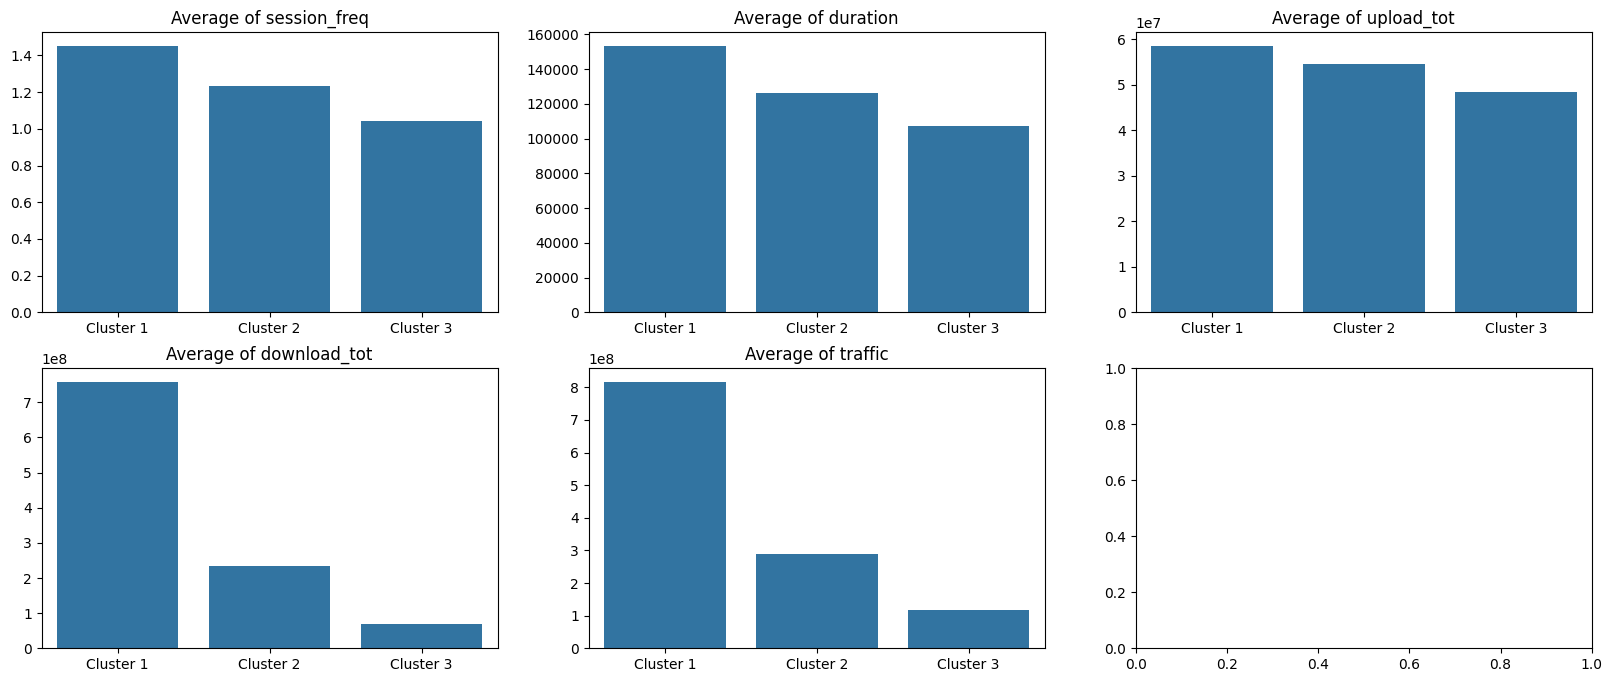

In [22]:
# create subplots
fig, axes = plt.subplots(ncols=NUM_COLS, nrows=num_rows, figsize=(20, num_rows * 4))

# plot the averages of the columns on the first row of the plot
row_cols = axes[0]
for i in range(3):
    ax = row_cols[i]
    col = customer_data.columns[i]
    ax.set_title(f'Average of {col}')

    # basic description for each cluster
    sns.barplot(data=[cluster_one_statistics[col]['mean'], cluster_two_statistics[col]['mean'], cluster_three_statistics[col]['mean']], ax=ax)
    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

# plot the averages of the columsn on the second row of the plot
row_cols = axes[1]
for i in range(3):
    ax = row_cols[i]
    i += 3
    col = customer_data.columns[i]
    if col == 'cluster': continue
    
    ax.set_title(f'Average of {col}')

    # basic description for each cluster
    sns.barplot(data=[cluster_one_statistics[col]['mean'], cluster_two_statistics[col]['mean'], cluster_three_statistics[col]['mean']], ax=ax)
    
    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.show()

- Plot the min, and max 

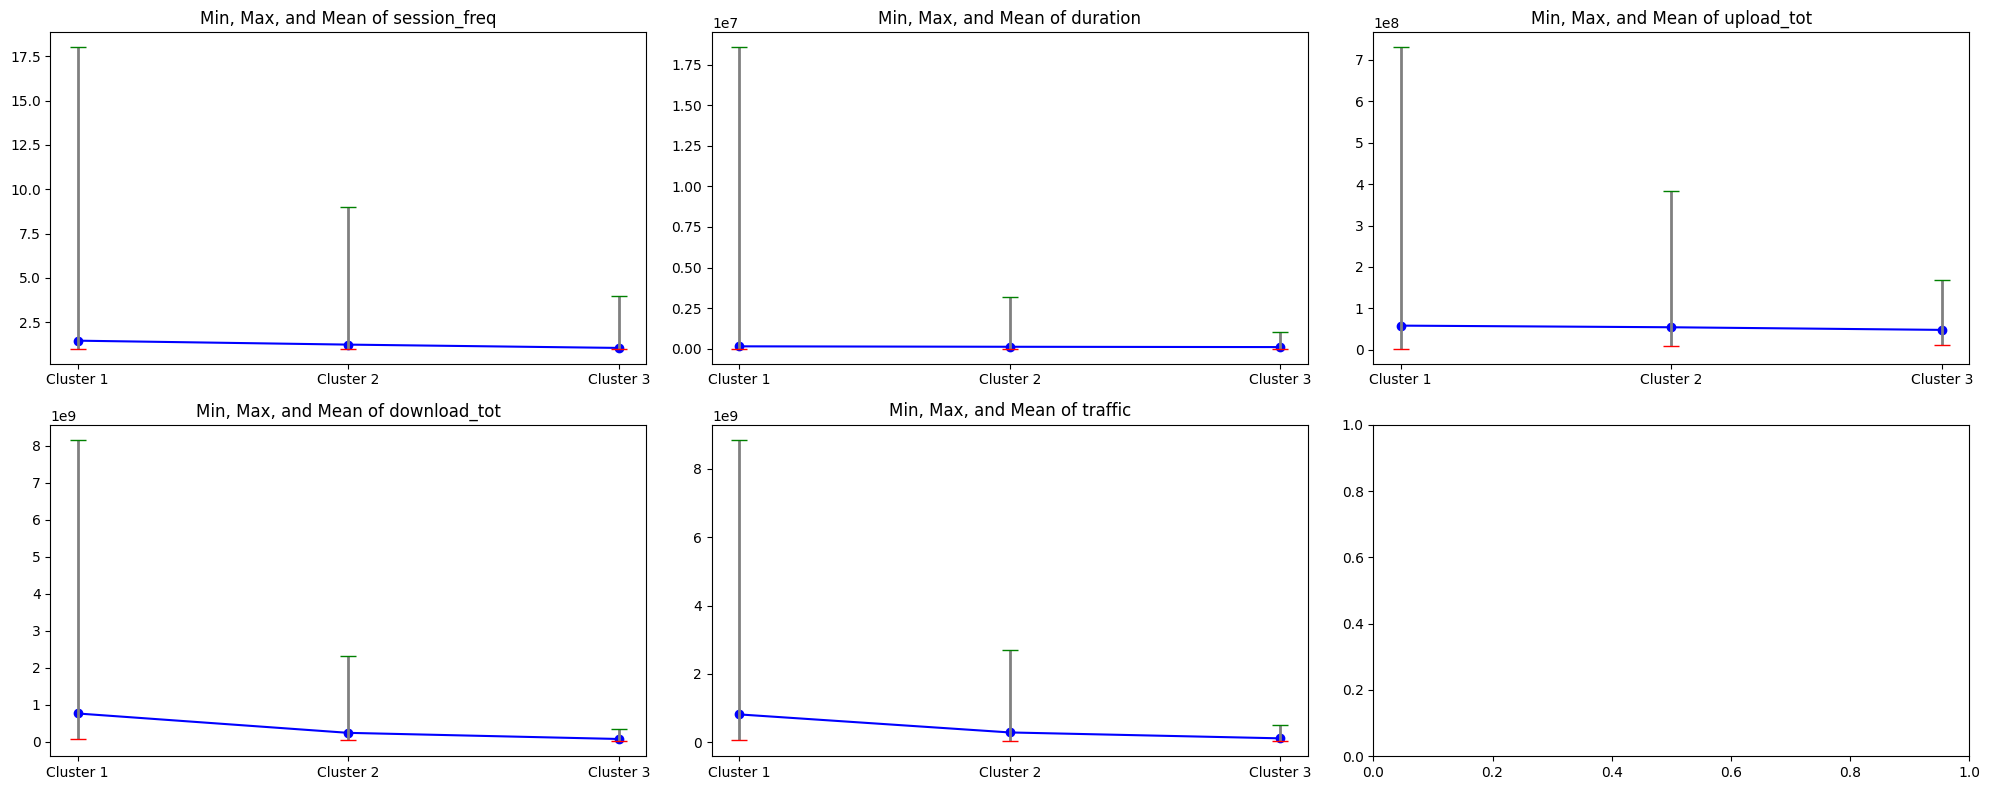

In [23]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(ncols=NUM_COLS, nrows=num_rows, figsize=(20, num_rows * 4))

# Plot the means, mins, and maxs with whisker lines for the first row of the plot
row_cols = axes[0]
for i in range(3):
    ax = row_cols[i]
    col = customer_data.columns[i]
    ax.set_title(f'Min, Max, and Mean of {col}')
    
    # Extract means, mins, and maxs for each cluster
    means = [cluster_one_statistics[col]['mean'], cluster_two_statistics[col]['mean'], cluster_three_statistics[col]['mean']]
    mins = [cluster_one_statistics[col]['min'], cluster_two_statistics[col]['min'], cluster_three_statistics[col]['min']]
    maxs = [cluster_one_statistics[col]['max'], cluster_two_statistics[col]['max'], cluster_three_statistics[col]['max']]
    
    # Plot means with markers
    ax.plot([0, 1, 2], means, marker='o', linestyle='-', color='b', label='Mean')
    
    # Add vertical lines to indicate the min-max range
    for j in range(3):
        ax.vlines(j, mins[j], maxs[j], colors='gray', linestyles='-', lw=2)  # Vertical line between min and max
        ax.plot(j, mins[j], marker='_', color='r', markersize=12)  # Marker for min
        ax.plot(j, maxs[j], marker='_', color='g', markersize=12)  # Marker for max

    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

# Plot the means, mins, and maxs with whisker lines for the second row of the plot
row_cols = axes[1]
for i in range(3):
    ax = row_cols[i]
    i += 3
    col = customer_data.columns[i]
    if col == 'cluster': continue
    
    ax.set_title(f'Min, Max, and Mean of {col}')

    # Extract means, mins, and maxs for each cluster
    means = [cluster_one_statistics[col]['mean'], cluster_two_statistics[col]['mean'], cluster_three_statistics[col]['mean']]
    mins = [cluster_one_statistics[col]['min'], cluster_two_statistics[col]['min'], cluster_three_statistics[col]['min']]
    maxs = [cluster_one_statistics[col]['max'], cluster_two_statistics[col]['max'], cluster_three_statistics[col]['max']]
    
    # Plot means with markers
    ax.plot([0, 1, 2], means, marker='o', linestyle='-', color='b', label='Mean')
    
    # Add vertical lines to indicate the min-max range
    for j in range(3):
        ax.vlines(j, mins[j], maxs[j], colors='gray', linestyles='-', lw=2)  # Vertical line between min and max
        ax.plot(j, mins[j], marker='_', color='r', markersize=12)  # Marker for min
        ax.plot(j, maxs[j], marker='_', color='g', markersize=12)  # Marker for max

    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.tight_layout()
plt.show()


- Plot the total

In [24]:
# now filter them into their respective groups and find the sum of every column
cluster_one_total = customer_data[customer_data['cluster'] == 0].drop(columns=['cluster']).sum()
cluster_two_total = customer_data[customer_data['cluster'] == 1].drop(columns=['cluster']).sum()
cluster_three_total = customer_data[customer_data['cluster'] == 2].drop(columns=['cluster']).sum()

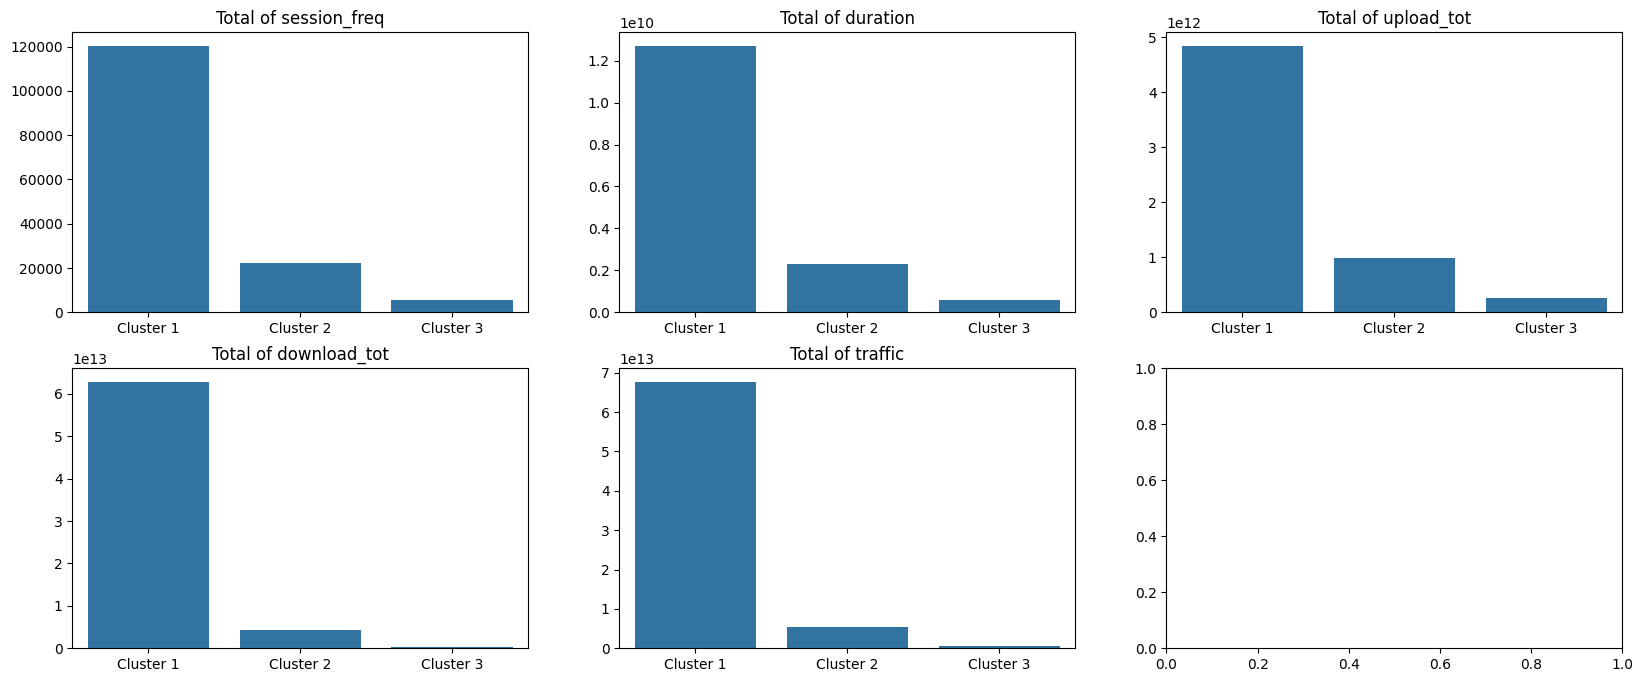

In [25]:
# create subplots
fig, axes = plt.subplots(ncols=NUM_COLS, nrows=num_rows, figsize=(20, num_rows * 4))

# plot the averages of the columns on the first row of the plot
row_cols = axes[0]
for i in range(3):
    ax = row_cols[i]
    col = customer_data.columns[i]
    ax.set_title(f'Total of {col}')

    # basic description for each cluster
    sns.barplot(data=[cluster_one_total[col], cluster_two_total[col], cluster_three_total[col]], ax=ax)
    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

# plot the averages of the columsn on the second row of the plot
row_cols = axes[1]
for i in range(3):
    ax = row_cols[i]
    i += 3
    col = customer_data.columns[i]
    if col == 'cluster': continue
    
    ax.set_title(f'Total of {col}')

    # basic description for each cluster
    sns.barplot(data=[cluster_one_total[col], cluster_two_total[col], cluster_three_total[col]], ax=ax)
    
    # Add labels for the clusters
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.show()

### Aggeregate the users total traffic per application and derive the top 10 most engaged users per application

1) Calculate the aggregate for every application available

In [32]:
# group the users' application usage per 
user_app_aggregation = customer_grouping.agg({
    "Youtube DL (Bytes)": "sum",
    "Youtube UL (Bytes)": "sum",
    "Netflix UL (Bytes)": "sum",
    "Netflix DL (Bytes)": "sum",
    "Google DL (Bytes)": "sum",
    "Google UL (Bytes)": "sum",
    "Gaming DL (Bytes)": "sum",
    "Gaming UL (Bytes)": "sum",
    "Email DL (Bytes)": "sum",
    "Email UL (Bytes)": "sum",
    "Social Media UL (Bytes)": "sum",
    "Social Media DL (Bytes)": "sum"
})

# renme the columns
user_app_aggregation = user_app_aggregation.rename(columns={
    "Youtube DL (Bytes)": "youtube_dl",
    "Youtube UL (Bytes)": "youtube_ul",
    "Netflix UL (Bytes)": "netflix_ul",
    "Netflix DL (Bytes)": "netflix_dl",
    "Google DL (Bytes)": "google_dl",
    "Google UL (Bytes)": "google_ul",
    "Gaming DL (Bytes)": "gaming_dl",
    "Gaming UL (Bytes)": "gaming_ul",
    "Email DL (Bytes)": "email_dl",
    "Email UL (Bytes)": "email_ul",
    "Social Media UL (Bytes)": "social_ul",
    "Social Media DL (Bytes)": "social_dl"  
})

# find the total traffic
user_app_aggregation['youtube'] = user_app_aggregation["youtube_dl"] + user_app_aggregation["youtube_ul"]
user_app_aggregation['google'] = user_app_aggregation["google_dl"] + user_app_aggregation["google_ul"]
user_app_aggregation['netflix'] = user_app_aggregation["netflix_dl"] + user_app_aggregation["netflix_ul"]
user_app_aggregation['gaming'] = user_app_aggregation["gaming_dl"] + user_app_aggregation["gaming_ul"]
user_app_aggregation['email'] = user_app_aggregation["email_dl"] + user_app_aggregation["email_ul"]
user_app_aggregation['social'] = user_app_aggregation["social_dl"] + user_app_aggregation["social_ul"]

# remove the placeholder columns
user_app_aggregation = user_app_aggregation.drop(columns=["youtube_dl", "youtube_ul", "netflix_ul", "netflix_dl", "google_dl", "google_ul", "gaming_dl", "gaming_ul", "email_dl", "email_ul", "social_ul", "social_dl"]
    )

2) Plot top 3 used applications

<Axes: >

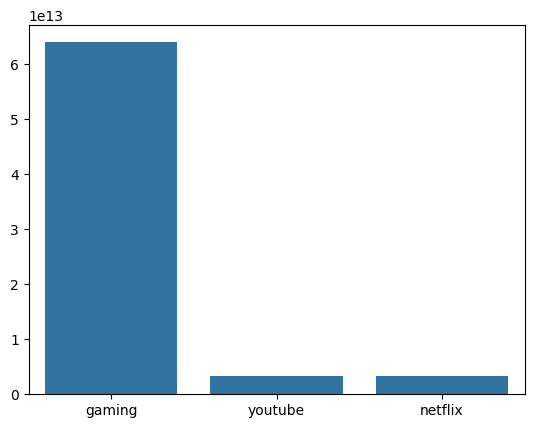

In [53]:
# find the total usage per app
total_app_usage = user_app_aggregation.sum()


# the select the top 3
sorted = total_app_usage.sort_values(ascending=False)
sns.barplot(sorted.head(3))